In [2]:
import numpy as np
import pandas as pd
import cv2
import imutils
from PIL import Image
import zbar

In [3]:
import tensorflow as tf
from keras_retinanet.models import load_model

In [4]:
import matplotlib.pyplot as plt

In [5]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io

In [6]:
# load the image and convert it to grayscale
image = cv2.imread("BarcodeDatasets/Dataset1/05102009081.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [10]:
def mask_from_contours(ref_img, contours):
    mask = np.zeros(ref_img.shape, np.uint8)
    mask = cv2.drawContours(mask, contours, 0, 255, -1)
    # return cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    return mask

In [12]:
mser = cv2.MSER_create()
regions, _ = mser.detectRegions(gray)

vis = image.copy()
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]

In [11]:
mser = cv2.MSER_create()
regions, _ = mser.detectRegions(gray)

vis = image.copy()
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
for hull in hulls:
    mean_val = cv.mean(im,mask = mask)
    print(x,y,w,h)
    
cv2.polylines(vis, hulls, 1, (0, 255, 0))
#cv2.imshow('img', vis)
mask = np.zeros((image.shape[0], image.shape[1], 1), dtype=np.uint8)
for contour in hulls:
    cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1)
    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(image)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mask)
plt.show()

NameError: name 'cv' is not defined

In [70]:
print(len(hulls[1]))

9


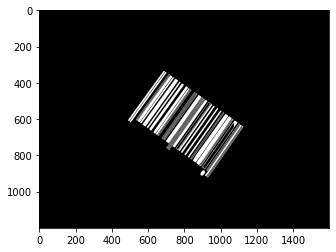

(165.32835820895522, 0.0, 0.0, 0.0) 432.5 20663670 1.719999805787322


In [14]:
kernel = np.ones((5,5), np.uint8)

# cnt = 0
selected_hulls = []
for index, hull in enumerate(hulls):
    
    mask = np.zeros(gray.shape, np.uint8)
    mask = cv2.drawContours(mask, [hull], -1, 255, -1)
    # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    # mask = mask_from_contours(image, hull)
    mean_val = cv2.mean(gray, mask = mask)
    area = cv2.contourArea(hull)
    
    (x, y), (width, height), angle = cv2.minAreaRect(hull)
    aspect_ratio = max(width, height) / min(width, height)
    
    # print(mean_val, area)
    if mean_val[0] < 100 and area > 1500 and aspect_ratio > 10.0:
        # print(np.unique(mask))
        # print(mask)
        selected_hulls.append(hull)
        # cnt += 1
        
    # if cnt==50:
    #     break
        
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# mask_d = cv2.dilate(mask, kernel, iterations=10)
mask_all = cv2.drawContours(mask, selected_hulls, -1, 255, -1)
ax.imshow(mask_all, cmap='Greys_r', vmin=0, vmax=255)
plt.show()
print(mean_val, area, np.sum(mask), aspect_ratio)

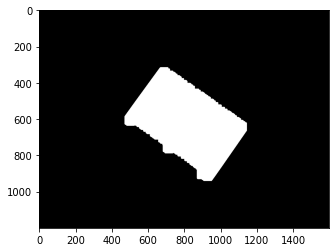

In [15]:
kernel = np.ones((5,5), np.uint8)
mask_d = cv2.dilate(mask_all, kernel, iterations=10)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mask_d, cmap='Greys_r', vmin=0, vmax=255)
plt.show()

1


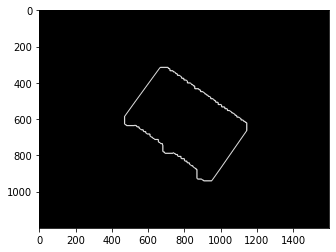

45.0


In [16]:
contours, hierarchy = cv2.findContours(mask_d, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_one = np.zeros(gray.shape, np.uint8)
mask_one = cv2.drawContours(mask_one, contours, -1, (255,255,255), 3)
print(len(contours))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mask_one, cmap='Greys_r', vmin=0, vmax=255)
plt.show()

rect = cv2.minAreaRect(contours[0])
print(angle)

In [34]:
def get_rotated_cropped_image(image, rect):
    (x, y), (width, height), angle = rect
    # image_center = tuple(np.array(image.shape[1::-1]) / 2)
    # rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    # rotated_image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    img_copy = image.copy()
    
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    Xs = [x[0] for x in box]
    Ys = [y[1] for y in box]
    x1 = min(Xs)
    y1 = min(Ys)
    x2 = max(Xs)
    y2 = max(Ys)

    rotated = False
    if angle < -45:
        angle += 90
        rotated = True

    center = (int((x1+x2)/2), int((y1+y2)/2))
    size = (int(x2-x1), int(y2-y1))

    rotation_matrix = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)

    cropped_barcode_reg = cv2.getRectSubPix(img_copy, size, center)
    cropped_barcode_reg = cv2.warpAffine(cropped_barcode_reg, rotation_matrix, size)
    
    cropped_width = width if not rotated else height 
    cropped_height = height if not rotated else width

    cropped_barcode_reg_tight = cv2.getRectSubPix(cropped_barcode_reg, 
                                                  (int(cropped_width), int(cropped_height)), 
                                                  (size[0]/2, size[1]/2))

    return cropped_barcode_reg_tight

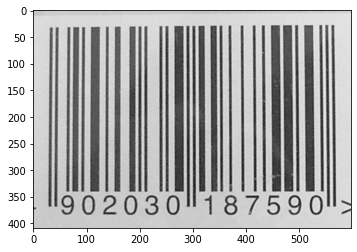

In [35]:
cropped_barcode_reg = get_rotated_cropped_image(gray, rect)
# aligned_mask = rotate_image(mask_one, angle)
# aligned_gray_masked = cv2.bitwise_and(aligned_gray, aligned_gray, mask=aligned_mask)

"""
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(aligned_gray, cmap='Greys_r', vmin=0, vmax=255)
plt.show()
"""

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(cropped_barcode_reg, cmap='Greys_r', vmin=0, vmax=255)
plt.show()